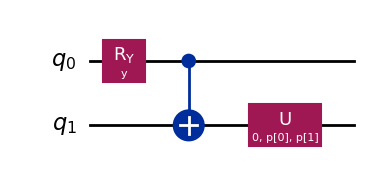

In [52]:
from sympy import *
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit_symb.quantum_info import Operator
from IPython import display

y = Parameter('y')
p = ParameterVector('p', length=2)

pqc = QuantumCircuit(2)
pqc.ry(y, 0)
pqc.cx(0, 1)
pqc.u(0, *p, 1)

pqc.draw('mpl')

In [53]:
op = Operator(pqc)
sm = op.to_sympy()

In [54]:
sm

Matrix([
[                     cos(y/2),                     -sin(y/2),                             0,                              0],
[                            0,                             0,                      sin(y/2),                       cos(y/2)],
[                            0,                             0, exp(I*(p[0] + p[1]))*cos(y/2), -exp(I*(p[0] + p[1]))*sin(y/2)],
[exp(I*(p[0] + p[1]))*sin(y/2), exp(I*(p[0] + p[1]))*cos(y/2),                             0,                              0]])

In [87]:
test = sm[3,0]
# x = Symbol('x')
# l = Symbol('l')
# test = cos(1+x)+l

In [92]:
class basmEngine:
	def __init__(self):
		self.basm = '''
%meta bmdef global registersize:32

%section terminal .romtext iomode:sync
	entry _start
_start:
	mov o0, r0
	j _start
%endsection

%section unary .romtext iomode:sync
	entry _start
_start:
	mov r0, i0
	mov o0, r0
	j _start
%endsection

%section binary .romtext iomode:sync
	entry _start
_start:
	mov r0, i0
	mov r1, i1
	mov o0, r0
	j _start
%endsection

'''
		self.inputs = []
		self.index = 0
	def run(self, expr):
		self.index+=1
		myIndex = int(self.index)
		out = "node_"+str(myIndex)+"_link"
		if myIndex == 1:
			self.basm += "%meta ioatt "+out+" cp:bm, type: output, index: 0\n"
		# self.basm += "#######" + str(expr) +" ## "+ str(myIndex)+"\n"	
		if len(expr.args) == 0:
			# This is an input node, create a link using the index among all the inputs, even if inputs grow the index will be unique
			if not str(expr) in self.inputs:
				self.inputs.append(str(expr))
			inIdx = self.inputs.index(str(expr))
			# self.basm += "%meta iodef "+out+"\n"
			self.basm += "%meta ioatt "+out+" cp:bm, index: "+str(inIdx)+", type: input\n"
			return out,myIndex
		else:
			# Create the processor
			if len(expr.args) == 1:
				self.basm += "%meta cpdef node_"+str(myIndex)+" romcode: unary, execmode: ha\n"
			else:
				self.basm += "%meta cpdef node_"+str(myIndex)+" romcode: binary, execmode: ha\n"
			# Create my side of the link, my caller will create the other side
			for i in range(len(expr.args)):
				arg=expr.args[i]
				inp,idx=self.run(arg)
				self.basm += "%meta ioatt "+inp+" cp: node_"+str(myIndex)+", type: input, index: "+str(i)+"\n"
				# Create link to the called nodeindex
			# self.basm += "%meta iodef "+out+"\n"
			self.basm += "%meta ioatt "+out+" cp: node_"+str(myIndex)+", type: output, index: 0\n"
			return out,myIndex


In [93]:
eng=basmEngine()
out=eng.run(test)

# Save to a file the basm code
with open("test.basm", "w") as text_file:
    text_file.write(eng.basm)

In [94]:
!basm -disable-dynamical-matching -chooser-min-word-size -chooser-force-same-name -o test.json test.basm

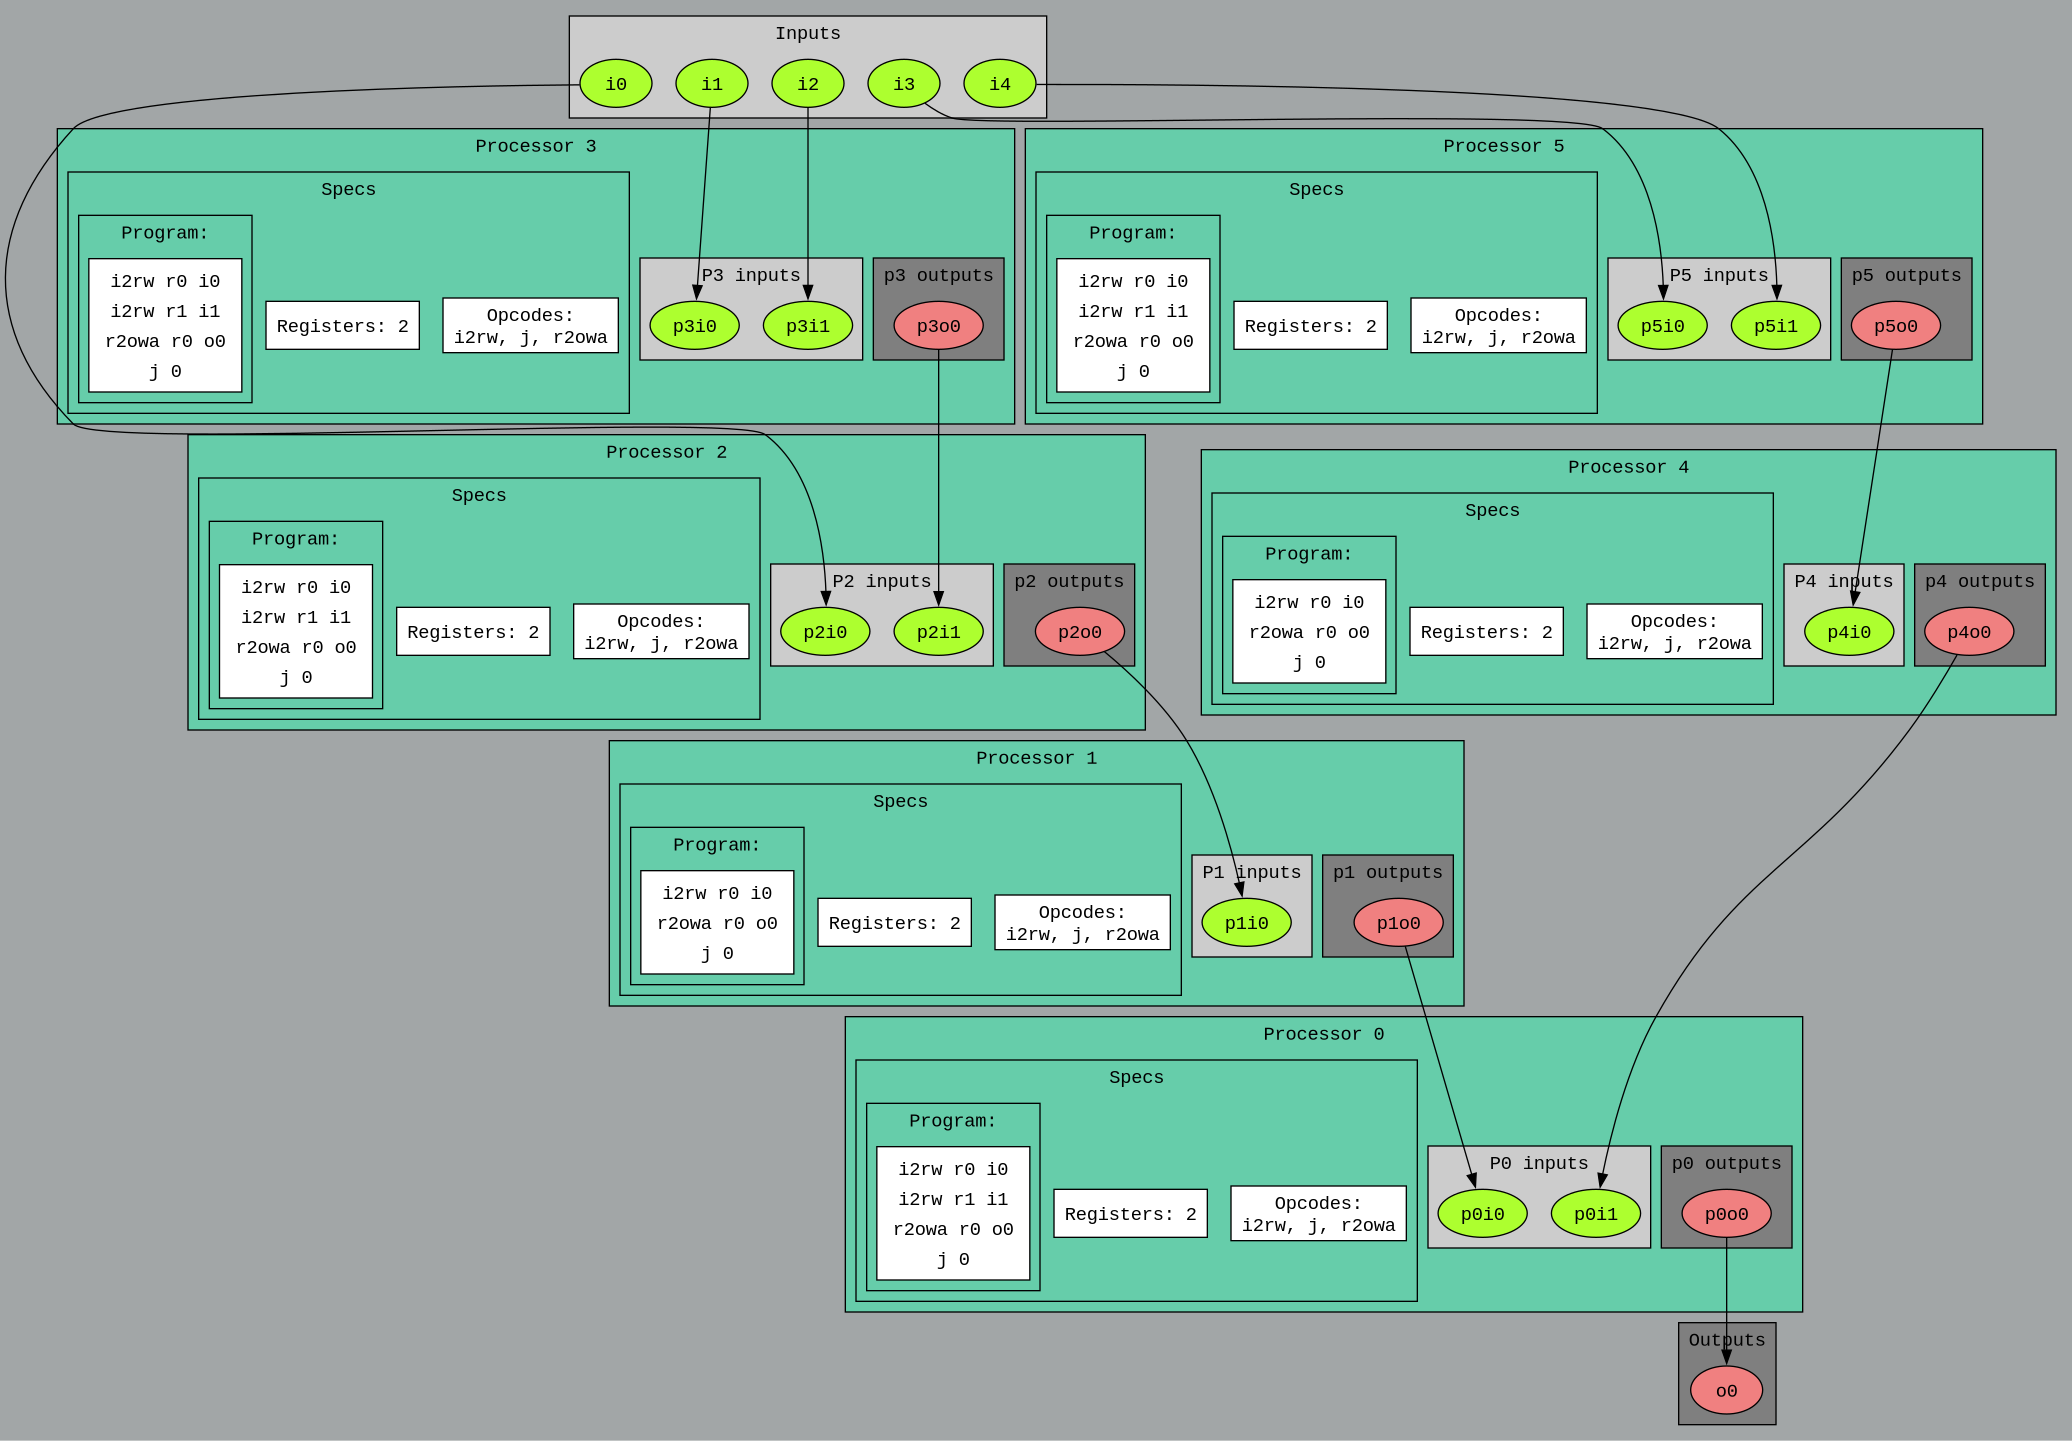

In [95]:
!bondmachine -bondmachine-file test.json -emit-dot -dot-detail 5 | dot -Tpng -o test.png
display.Image("test.png")

In [ ]:
for arg in preorder_traversal(test):
    print(arg)
    print(arg.func)
    print(arg.args)
    print("---")